本页面练习pytorch模型。参考pytorch官方教程页面中的同名部分

https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html  
https://pytorch.org/tutorials/beginner/nn_tutorial.html 

## `torch.nn.Module` and `torch.nn.Parameter`
一般我们定义一个新的神经网络时，继承自类`torch.nn.Module`,，其中所有模型参数是类`torch.nn.Parameter`的instance.These parameters may be accessed through the `parameters()` method on the Module class.

In [1]:
import torch

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(100, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 10)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

tinymodel = TinyModel()

print('The model:')
print(tinymodel)

print('\n\nJust one layer:')
print(tinymodel.linear2)

print('\n\nModel params:')
for param in tinymodel.parameters():
    print(param)

print('\n\nLayer params:')
for param in tinymodel.linear2.parameters():
    print(param)

The model:
TinyModel(
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


Just one layer:
Linear(in_features=200, out_features=10, bias=True)


Model params:
Parameter containing:
tensor([[ 0.0665, -0.0317, -0.0161,  ...,  0.0247, -0.0110,  0.0676],
        [ 0.0903,  0.0648, -0.0361,  ..., -0.0463,  0.0501,  0.0814],
        [ 0.0472,  0.0279, -0.0602,  ..., -0.0508, -0.0065,  0.0562],
        ...,
        [ 0.0020,  0.0845, -0.0537,  ...,  0.0672,  0.0140,  0.0595],
        [ 0.0692, -0.0873,  0.0907,  ..., -0.0228, -0.0061, -0.0294],
        [ 0.0515, -0.0577,  0.0635,  ..., -0.0032, -0.0167,  0.0475]],
       requires_grad=True)
Parameter containing:
tensor([-0.0523,  0.0792, -0.0380,  0.0412, -0.0628, -0.0371, -0.0236,  0.0607,
        -0.0789, -0.0279,  0.0750, -0.0321,  0.0977, -0.0294, -0.0993,  0.0419,
         0.0723,  0.0818,  0.0931,  0.05

## Common Layer Types
### Linear Layers
If a model has m inputs and n outputs, the weights will be an m x n matrix. For example:  

注意在参数中有bias，即常量维度

In [2]:
lin = torch.nn.Linear(3, 2)
x = torch.rand(1, 3)
print('Input:')
print(x)

print('\n\nWeight and Bias parameters:')
for param in lin.parameters():
    print(param)

y = lin(x)
print('\n\nOutput:')
print(y)

Input:
tensor([[0.0950, 0.4133, 0.2453]])


Weight and Bias parameters:
Parameter containing:
tensor([[-0.2651, -0.2092,  0.0635],
        [ 0.0273, -0.2154,  0.3392]], requires_grad=True)
Parameter containing:
tensor([ 0.3514, -0.0401], requires_grad=True)


Output:
tensor([[ 0.2553, -0.0434]], grad_fn=<AddmmBackward0>)


### Convolutional Layers
torch.nn.Conv2d(input_channel, output_channel, kernel_size),第一个参数是输入的channel数量，对于黑白图像取1，对于RGB三通道图像取3，第二个参数是输出的卷积特征的个数，第三个是卷积核大小。Here, the “5” means we’ve chosen a 5x5 kernel. (If you want a kernel with height different from width, you can specify a tuple for this argument - e.g., (3, 5) to get a 3x5 convolution kernel.)

In [3]:
import torch.functional as F


class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Recurrent Layers
下图展示了循环神经网络在三个相邻时间步的计算逻辑。在任意时间步 $t$, 隐状态的计算可以被视为:
1. 拼接当前时间步 $t$ 的输入 $\mathbf{X}_{t}$ 和前一时间步 $t - 1$ 的隐状态 $\mathbf{H}$ ；
2. 将拼接的结果送入带有激活函数 $\phi$ 的全连接层。全连接层的输出是当前时间步 $t$ 的隐状态 $\mathbf{H}_{t}$ 。
在本例中, 模型参数是 $\mathbf{W}_{xh}$ 和 $\mathbf{W}_{hh}$ 的拼接, 以及 $\mathbf{b}_{h}$ 的偏置, 所有这些参数都来自 (8.4.5)。当前时间步 $t$ 的隐 状态 $\mathbf{H}_{t}$ 将参与计算下一时间步 $t+1$ 的隐状态 $\mathbf{H}_{t}$ 。而且 $\mathbf{H}_{t}$ 还将送入全连接输出层, 用于计算当前时间步 $t$ 的输出 $\mathbf{O}_{t}$ 。
![rnn](https://zh.d2l.ai/_images/rnn.svg)

In [4]:
class LSTMTagger(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocabulary_size, tagset_size):
        super(self, LSTMTagger).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = torch.nn.Embedding(
            vocabulary_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = torch.nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        print(embeds)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))  
        # input of shape (seq_len, batch, input_size)
        # output of shape (seq_len, batch, num_directions * hidden_size):
        tag_space = self.hidden2tag(lstm_out.view(len(sentence),-1))  
        tag_scores = F.log_softmax(tag_space,dim=1)
        return tag_scores
    

## maxpooling

In [5]:
my_tensor = torch.rand(1, 6, 6)
print(my_tensor)

maxpool_layer = torch.nn.MaxPool2d(3)
print(maxpool_layer(my_tensor))

tensor([[[0.9950, 0.1662, 0.9341, 0.5566, 0.4886, 0.1871],
         [0.1016, 0.8775, 0.2024, 0.3564, 0.0677, 0.9847],
         [0.5776, 0.6127, 0.0346, 0.2698, 0.3419, 0.5168],
         [0.7070, 0.2477, 0.2281, 0.7483, 0.2758, 0.1943],
         [0.6796, 0.4139, 0.2979, 0.0630, 0.5987, 0.2688],
         [0.5326, 0.6068, 0.2797, 0.7058, 0.2514, 0.4582]]])
tensor([[[0.9950, 0.9847],
         [0.7070, 0.7483]]])


## dropout layers
Dropout layers are a tool for encouraging sparse representations in your model - that is, pushing it to do inference with less data.

Dropout layers work by randomly setting parts of the input tensor during training - dropout layers are always turned off for inference. This forces the model to learn against this masked or reduced dataset. For example:

In [6]:
my_tensor = torch.rand(1, 4, 4)

dropout = torch.nn.Dropout(p=0.4)
print(my_tensor)
print(dropout(my_tensor))

tensor([[[0.8789, 0.3455, 0.1694, 0.9645],
         [0.3926, 0.3636, 0.8117, 0.5433],
         [0.6180, 0.2305, 0.5149, 0.3590],
         [0.4198, 0.3174, 0.2045, 0.9115]]])
tensor([[[1.4648, 0.0000, 0.2823, 1.6074],
         [0.0000, 0.6059, 1.3528, 0.9054],
         [1.0300, 0.0000, 0.8581, 0.0000],
         [0.6997, 0.5291, 0.0000, 0.0000]]])


## WHAT IS TORCH.NN REALLY
接下来这一部分参考pytorch官方教程中的同名部分

https://pytorch.org/tutorials/beginner/nn_tutorial.html

使用MNIST数据集，每个图像是28*28

(50000, 784)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


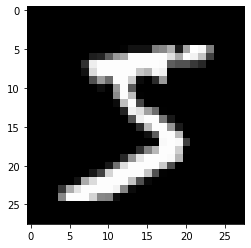

In [8]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)
        
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
        
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)   

import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

### No torch.nn

In [17]:
import math
# We are initializing the weights here with Xavier initialisation (by multiplying with 1/sqrt(n))
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)
print(f"weights: \n {weights} \n bias:\n {bias}")

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)  # @ stands for the matrix multiplication operation.

bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(f"preds:\n {preds[0]}\n preds.shape:\n {preds.shape}")

weights: 
 tensor([[-0.0168,  0.0169, -0.0105,  ...,  0.0385,  0.0337,  0.0583],
        [ 0.0036, -0.0311, -0.0153,  ..., -0.0311, -0.0082,  0.0361],
        [ 0.0639, -0.0398, -0.0277,  ...,  0.0520, -0.0176, -0.0053],
        ...,
        [-0.0447,  0.0192, -0.0362,  ..., -0.0046,  0.0104,  0.0075],
        [ 0.0277,  0.0177, -0.0007,  ...,  0.0419, -0.0116,  0.0184],
        [-0.0528, -0.0058,  0.0350,  ..., -0.0061, -0.0236, -0.0245]],
       requires_grad=True) 
 bias:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
preds:
 tensor([-3.1698, -1.8879, -2.2151, -2.3113, -2.5935, -2.6347, -2.4085, -2.0691,
        -1.9722, -2.3389], grad_fn=<SelectBackward0>)
 preds.shape:
 torch.Size([64, 10])


In [19]:
def nll(input, target):
    """implement negative log-likelihood to use as the loss function """
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

yb = y_train[0:bs]
print(loss_func(preds, yb))

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(f"accurancy: {accuracy(preds, yb)}")

tensor(2.3506, grad_fn=<NegBackward0>)
accurancy: 0.046875


### use torch.nn.functional


In [20]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.3506, grad_fn=<NllLossBackward0>) tensor(0.0469)


### refactor using nn.Module

In [25]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super(Mnist_Logistic, self).__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3809, grad_fn=<NllLossBackward0>)


### refactor using nn.Linear

In [29]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super(Mnist_Logistic,self).__init__()
        self.fc1 = nn.Linear(784,10)
    def forward(self, xb):
        return self.fc1(xb)
model = Mnist_Logistic()
print(model)
criterion = nn.CrossEntropyLoss()
print(criterion(model(xb), yb))


Mnist_Logistic(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)
tensor(2.3352, grad_fn=<NllLossBackward0>)


### refactor using optim

In [30]:
from torch import optim
optimizer = optim.SGD(model.parameters(),lr=1e-3)


### refactor using dataset & dataloader 

In [35]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)

from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=bs,shuffle=True)


        
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2) 


epochs=2
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred= model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
    print(epoch, valid_loss / len(valid_dl))

0 tensor(1.6879)
1 tensor(1.3220)


### switch to CNN


In [36]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [37]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

TypeError: fit() takes 0 positional arguments but 6 were given